In [1]:
# Import required libraries
import json
import spacy
import numpy as np
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully")

Libraries imported successfully


## Step 1: Load Data

Load the KWIC JSON file and corresponding annotations. Update the file paths below to point to your data.

In [3]:
# ========================================
# UPDATE THESE PATHS TO YOUR FILES
# ========================================

# Path to your KWIC JSON file (e.g., 'kwic_coca_best_method.json')
KWIC_FILE = Path('./exports/kwic_coca_best_system.json')

# Path to your annotations file (e.g., 'kwic_coca_best_method_annotations.json')
ANNOTATIONS_FILE = Path('./annotator_app/annotations/kwic_coca_best_system_annotations.json')

# ========================================

# Verify files exist
if not KWIC_FILE.exists():
    print(f"⚠️ KWIC file not found: {KWIC_FILE}")
    print("Please update KWIC_FILE path above")
else:
    print(f"✓ Found KWIC file: {KWIC_FILE}")

if not ANNOTATIONS_FILE.exists():
    print(f"⚠️ Annotations file not found: {ANNOTATIONS_FILE}")
    print("Please update ANNOTATIONS_FILE path above")
else:
    print(f"✓ Found annotations file: {ANNOTATIONS_FILE}")

✓ Found KWIC file: exports/kwic_coca_best_system.json
✓ Found annotations file: annotator_app/annotations/kwic_coca_best_system_annotations.json


In [4]:
# Load the data
with open(KWIC_FILE, 'r', encoding='utf-8') as f:
    kwic_data = json.load(f)

with open(ANNOTATIONS_FILE, 'r', encoding='utf-8') as f:
    annotations = json.load(f)

# Count items
total_kwic = sum(len(items) for items in kwic_data.values())
total_annotations = sum(len(genre_anns) for genre_anns in annotations.values())

print(f"📊 Data Summary:")
print(f"   Total KWIC items: {total_kwic:,}")
print(f"   Total annotations: {total_annotations:,}")
print(f"   Genres: {len(kwic_data)}")

📊 Data Summary:
   Total KWIC items: 150
   Total annotations: 147
   Genres: 103


## Step 2: Text Normalization

The Flask app normalizes punctuation to clean up corpus artifacts (e.g., " , " → ","). We'll replicate that here.

In [5]:
import re

def normalize_punctuation(text):
    """Normalize spacing around punctuation marks."""
    if not text:
        return text
    
    # Remove spaces before common punctuation marks
    text = re.sub(r'\s+([.,;:!?)])', r'\1', text)
    # Remove spaces after opening punctuation
    text = re.sub(r'([(])\s+', r'\1', text)
    # Fix multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # Fix space before apostrophes in contractions
    text = re.sub(r"\s+'([st]|re|ve|ll|d|m)\b", r"'\1", text)
    # Fix n't contractions
    text = re.sub(r"\s+n't\b", r"n't", text)
    
    return text.strip()

# Add cleaned text to KWIC data
for genre_key, items in kwic_data.items():
    for item in items:
        if 'context' in item:
            item['text_clean'] = normalize_punctuation(item['context'])
        if 'full_text' in item:
            item['full_text_clean'] = normalize_punctuation(item['full_text'])

print("✓ Text normalization complete")

✓ Text normalization complete


In [22]:
## Display a random sample of text for verification
import random
sample_genre = random.choice(list(kwic_data.keys()))
sample_items = random.sample(kwic_data[sample_genre], min(3, len(kwic_data[sample_genre])))
print(f"\n🔍 Sample texts from genre '{sample_genre}':")
for i, item in enumerate(sample_items, 1):
    print(f"\n--- Sample {i} ---")
    print(item['text_clean'].replace('**', ''))


🔍 Sample texts from genre 'spok_2009':

--- Sample 1 ---
, I don't think people in this country believe that the federal government controlling everything is, is the best system of last resort. I think we should have more flexibility in the states to solve their own problems.

--- Sample 2 ---
, but were all kind of looking over each others shoulders, too, I -- I think thats the best system, because the regulators could have done a lot of things better, too. So, we do nt

--- Sample 3 ---
the mistake we've made. " @!ARNOLD: But he also said on another show that they had the best system in the world. @!HANNITY: He didn't say that here. @!ARNOLD: I don't mean he


## Step 3: Load spaCy Model

We use spaCy for POS tagging. The app uses `en_core_web_lg` with fallback to `en_core_web_sm`.

In [23]:
# Load spaCy model
try:
    nlp = spacy.load('en_core_web_lg')
    print("✓ Loaded spaCy model: en_core_web_lg")
except OSError:
    nlp = spacy.load('en_core_web_sm')
    print("✓ Loaded spaCy model: en_core_web_sm (fallback)")

print(f"   Pipeline components: {nlp.pipe_names}")

✓ Loaded spaCy model: en_core_web_lg
   Pipeline components: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


## Step 4: Extract POS Features

For each annotated concordance line, we extract:
- **POS tags**: Part-of-speech for each token (NOUN, VERB, ADJ, etc.)
- **POS bigrams**: Adjacent POS pairs (e.g., "DET_NOUN", "ADJ_NOUN")
- **POS trigrams**: Three consecutive POS tags

These features capture syntactic patterns without being tied to specific words.

In [24]:
# Organize data by classification
classification_data = {
    'literal': [],
    'figurative': [],
    'neither': [],
    'unclear': []
}

# Process annotated items
for genre_key, items in kwic_data.items():
    for idx, item in enumerate(items):
        # Get annotation
        annotation = annotations.get(genre_key, {}).get(str(idx), {})
        if not annotation:
            continue
        
        classification = annotation.get('classification')
        if not classification or classification not in classification_data:
            continue
        
        # Get cleaned text
        context = item.get('text_clean', item.get('context', ''))
        clean_text = context.replace('**', '')  # Remove KWIC markers
        
        # Process with spaCy
        doc = nlp(clean_text)
        
        # Extract POS features
        pos_tags = [token.pos_ for token in doc]
        pos_bigrams = [f"{pos_tags[i]}_{pos_tags[i+1]}" for i in range(len(pos_tags)-1)]
        pos_trigrams = [f"{pos_tags[i]}_{pos_tags[i+1]}_{pos_tags[i+2]}" for i in range(len(pos_tags)-2)]
        
        classification_data[classification].append({
            'text': context,
            'genre': genre_key,
            'text_id': item.get('text_id', ''),
            'pos_tags': pos_tags,
            'pos_bigrams': pos_bigrams,
            'pos_trigrams': pos_trigrams,
            'notes': annotation.get('notes', '')
        })

# Print summary
print("📊 Classification Summary:")
for classification, items in classification_data.items():
    print(f"   {classification.capitalize()}: {len(items)} items")

📊 Classification Summary:
   Literal: 53 items
   Figurative: 69 items
   Neither: 9 items
   Unclear: 16 items


## Step 5: Feature Engineering

Convert POS patterns into numerical feature vectors suitable for K-Means clustering.

**Process**:
1. Collect all unique POS tags, bigrams, and trigrams across the dataset
2. For each concordance line, create a count vector
3. Normalize features using StandardScaler

In [25]:
def create_feature_vectors(items):
    """Convert POS patterns to numerical feature vectors."""
    
    # Collect all unique features
    all_pos_tags = set()
    all_bigrams = set()
    all_trigrams = set()
    
    for item in items:
        all_pos_tags.update(item['pos_tags'])
        all_bigrams.update(item['pos_bigrams'])
        all_trigrams.update(item['pos_trigrams'])
    
    print(f"   Unique POS tags: {len(all_pos_tags)}")
    print(f"   Unique bigrams: {len(all_bigrams)}")
    print(f"   Unique trigrams: {len(all_trigrams)}")
    
    # Create feature vectors
    feature_vectors = []
    for item in items:
        # Count POS tags
        pos_counts = Counter(item['pos_tags'])
        tag_vector = [pos_counts.get(tag, 0) for tag in sorted(all_pos_tags)]
        
        # Count bigrams
        bigram_counts = Counter(item['pos_bigrams'])
        bigram_vector = [bigram_counts.get(bg, 0) for bg in sorted(all_bigrams)]
        
        # Count trigrams
        trigram_counts = Counter(item['pos_trigrams'])
        trigram_vector = [trigram_counts.get(tg, 0) for tg in sorted(all_trigrams)]
        
        # Combine all features
        feature_vectors.append(tag_vector + bigram_vector + trigram_vector)
    
    return np.array(feature_vectors), sorted(all_pos_tags), sorted(all_bigrams), sorted(all_trigrams)

# Test with one classification
if classification_data['literal']:
    X_test, tags, bigrams, trigrams = create_feature_vectors(classification_data['literal'])
    print(f"\n✓ Feature vector shape: {X_test.shape}")
    print(f"   (rows = concordance lines, columns = features)")

   Unique POS tags: 17
   Unique bigrams: 175
   Unique trigrams: 659

✓ Feature vector shape: (53, 851)
   (rows = concordance lines, columns = features)


## Step 6: Perform Clustering

Apply K-Means clustering to each classification category separately.

**Clustering Parameters**:
- Number of clusters: min(5, max(2, n_samples // 3))
- Features are normalized using StandardScaler
- Random state = 42 for reproducibility

In [26]:
# Perform clustering for each classification
clustering_results = {}

for classification, items in classification_data.items():
    if len(items) < 2:
        print(f"⚠️ {classification}: Insufficient data ({len(items)} items)")
        continue
    
    print(f"\n{'='*60}")
    print(f"Clustering: {classification.upper()}")
    print(f"{'='*60}")
    
    # Create feature vectors
    X, pos_tags, pos_bigrams, pos_trigrams = create_feature_vectors(items)
    
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Determine number of clusters
    n_samples = len(items)
    n_clusters = min(5, max(2, n_samples // 3))
    print(f"   Samples: {n_samples}, Clusters: {n_clusters}")
    
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Organize by cluster
    clusters = {}
    for i, label in enumerate(cluster_labels):
        label = int(label)
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(items[i])
    
    # Calculate cluster statistics
    cluster_stats = []
    for label in sorted(clusters.keys()):
        cluster_items = clusters[label]
        
        # Aggregate POS patterns in this cluster
        all_tags = []
        all_bigrams = []
        for idx in [i for i, l in enumerate(cluster_labels) if l == label]:
            all_tags.extend(items[idx]['pos_tags'])
            all_bigrams.extend(items[idx]['pos_bigrams'])
        
        top_tags = Counter(all_tags).most_common(5)
        top_bigrams = Counter(all_bigrams).most_common(5)
        
        cluster_stats.append({
            'label': label,
            'size': len(cluster_items),
            'percentage': round(len(cluster_items) / len(items) * 100, 1),
            'top_tags': top_tags,
            'top_bigrams': top_bigrams,
            'items': cluster_items
        })
        
        print(f"\n   Cluster {label} ({len(cluster_items)} items, {cluster_stats[-1]['percentage']}%):")
        print(f"      Top POS tags: {', '.join([f'{tag}({ct})' for tag, ct in top_tags[:3]])}")
        print(f"      Top bigrams: {', '.join([f'{bg}({ct})' for bg, ct in top_bigrams[:3]])}")
    
    clustering_results[classification] = {
        'n_clusters': n_clusters,
        'cluster_stats': cluster_stats,
        'features': X,
        'features_scaled': X_scaled,
        'labels': cluster_labels,
        'model': kmeans
    }

print(f"\n{'='*60}")
print("✓ Clustering complete for all classifications")


Clustering: LITERAL
   Unique POS tags: 17
   Unique bigrams: 175
   Unique trigrams: 659
   Samples: 53, Clusters: 5

   Cluster 0 (18 items, 34.0%):
      Top POS tags: NOUN(130), PUNCT(94), ADP(82)
      Top bigrams: NOUN_PUNCT(43), ADJ_NOUN(41), DET_NOUN(34)

   Cluster 1 (1 items, 1.9%):
      Top POS tags: NOUN(8), VERB(6), DET(6)
      Top bigrams: DET_NOUN(4), VERB_DET(3), NOUN_CCONJ(2)

   Cluster 2 (32 items, 60.4%):
      Top POS tags: NOUN(203), PRON(177), PUNCT(160)
      Top bigrams: NOUN_PUNCT(72), ADJ_NOUN(71), PUNCT_PRON(61)

   Cluster 3 (1 items, 1.9%):
      Top POS tags: NOUN(12), PUNCT(8), DET(5)
      Top bigrams: ADJ_NOUN(3), ADP_PROPN(3), PUNCT_NOUN(3)

   Cluster 4 (1 items, 1.9%):
      Top POS tags: NOUN(8), ADV(5), ADP(4)
      Top bigrams: NOUN_ADP(3), ADP_DET(3), DET_NOUN(3)

Clustering: FIGURATIVE
   Unique POS tags: 17
   Unique bigrams: 193
   Unique trigrams: 775
   Samples: 69, Clusters: 5

   Cluster 0 (65 items, 94.2%):
      Top POS tags: NOUN(46

## Step 7: Visualize Clustering Results

Create visualizations to understand the cluster distributions and characteristics.

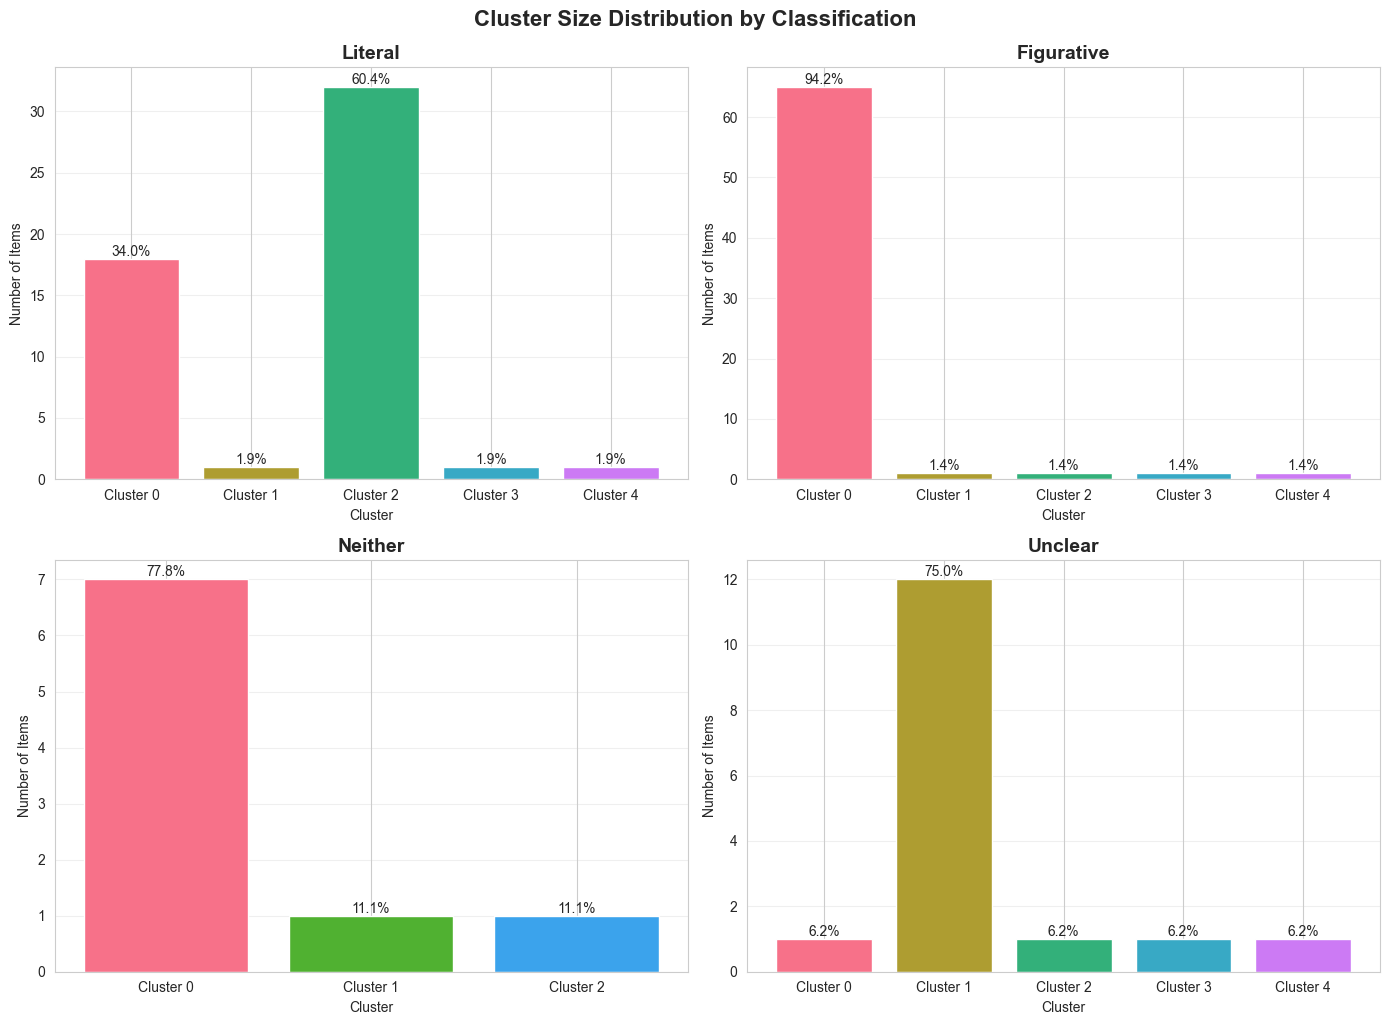

In [27]:
# Visualization 1: Cluster size distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (classification, results) in enumerate(clustering_results.items()):
    if idx >= 4:
        break
    
    ax = axes[idx]
    stats = results['cluster_stats']
    
    cluster_labels = [f"Cluster {s['label']}" for s in stats]
    cluster_sizes = [s['size'] for s in stats]
    
    bars = ax.bar(cluster_labels, cluster_sizes, color=sns.color_palette("husl", len(stats)))
    ax.set_title(f"{classification.capitalize()}", fontsize=14, fontweight='bold')
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Number of Items")
    ax.grid(axis='y', alpha=0.3)
    
    # Add percentage labels
    for bar, stat in zip(bars, stats):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f"{stat['percentage']}%",
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.suptitle("Cluster Size Distribution by Classification", 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

In [28]:
# Visualization 2: Top POS patterns by cluster
for classification, results in clustering_results.items():
    print(f"\n{'='*80}")
    print(f"POS Pattern Analysis: {classification.upper()}")
    print(f"{'='*80}\n")
    
    for stat in results['cluster_stats']:
        print(f"Cluster {stat['label']} (n={stat['size']}, {stat['percentage']}%)")
        print("-" * 60)
        
        print("Top POS Tags:")
        for tag, count in stat['top_tags']:
            bar = '█' * int(count / max(c for _, c in stat['top_tags']) * 30)
            print(f"  {tag:12s} {bar} {count}")
        
        print("\nTop POS Bigrams:")
        for bigram, count in stat['top_bigrams']:
            bar = '█' * int(count / max(c for _, c in stat['top_bigrams']) * 30)
            print(f"  {bigram:20s} {bar} {count}")
        
        print()


POS Pattern Analysis: LITERAL

Cluster 0 (n=18, 34.0%)
------------------------------------------------------------
Top POS Tags:
  NOUN         ██████████████████████████████ 130
  PUNCT        █████████████████████ 94
  ADP          ██████████████████ 82
  DET          ██████████████████ 79
  VERB         ██████████████ 64

Top POS Bigrams:
  NOUN_PUNCT           ██████████████████████████████ 43
  ADJ_NOUN             ████████████████████████████ 41
  DET_NOUN             ███████████████████████ 34
  DET_ADJ              ███████████████████████ 34
  NOUN_ADP             ███████████████████████ 34

Cluster 1 (n=1, 1.9%)
------------------------------------------------------------
Top POS Tags:
  NOUN         ██████████████████████████████ 8
  VERB         ██████████████████████ 6
  DET          ██████████████████████ 6
  PUNCT        ██████████████████ 5
  CCONJ        ███████████ 3

Top POS Bigrams:
  DET_NOUN             ██████████████████████████████ 4
  VERB_DET             ████

## Step 8: Examine Representative Examples

Look at actual concordance lines from each cluster to understand the patterns.

In [29]:
# Display representative examples from each cluster
for classification, results in clustering_results.items():
    print(f"\n{'='*80}")
    print(f"Representative Examples: {classification.upper()}")
    print(f"{'='*80}\n")
    
    for stat in results['cluster_stats']:
        print(f"Cluster {stat['label']} (n={stat['size']})")
        print("-" * 80)
        
        # Show first 3 examples from this cluster
        for i, item in enumerate(stat['items'][:3]):
            text = item['text'][:100] + "..." if len(item['text']) > 100 else item['text']
            print(f"  {i+1}. {text}")
            print(f"     POS: {' '.join(item['pos_tags'][:15])}...")
            if item['notes']:
                print(f"     Notes: {item['notes']}")
            print()
        
        if len(stat['items']) > 3:
            print(f"  ... and {len(stat['items']) - 3} more items\n")


Representative Examples: LITERAL

Cluster 0 (n=18)
--------------------------------------------------------------------------------
  1. these reasons, I favored the Troy-Bilt of the two self-propelled models I tested. The Troy-Bilt also...
     POS: DET NOUN PUNCT PRON VERB DET PROPN PUNCT PROPN ADP DET NUM NOUN PUNCT VERB...

  2. Jeff Niemann and shortstop Reid Brignac) for three months of Sabathia's services and still have the ...
     POS: PROPN PROPN CCONJ VERB PROPN PROPN PUNCT ADP NUM NOUN ADP PROPN PART NOUN CCONJ...

  3. told me. " The more complex an issue is, the less possible it is to actually know the **best system*...
     POS: VERB PRON PUNCT PUNCT DET ADV ADJ DET NOUN AUX PUNCT PRON ADV ADJ PRON...

  ... and 15 more items

Cluster 1 (n=1)
--------------------------------------------------------------------------------
  1. broadening the graduate experience and reducing the time to degree, Lane said, but the US still has ...
     POS: VERB DET NOUN NOUN CCONJ VERB D

## Step 9: Cross-Classification Analysis

**Key Finding**: Examine whether cluster patterns are consistent across classifications.

If the clustering reveals **two distinct groups** across multiple classifications, this suggests that the syntactic structure (not just semantic meaning) drives the grouping.

In [30]:
# Create summary DataFrame for cross-classification comparison
summary_data = []

for classification, results in clustering_results.items():
    for stat in results['cluster_stats']:
        summary_data.append({
            'Classification': classification,
            'Cluster': stat['label'],
            'Size': stat['size'],
            'Percentage': stat['percentage'],
            'Top_Tag_1': stat['top_tags'][0][0] if stat['top_tags'] else '',
            'Top_Tag_2': stat['top_tags'][1][0] if len(stat['top_tags']) > 1 else '',
            'Top_Bigram_1': stat['top_bigrams'][0][0] if stat['top_bigrams'] else '',
            'Top_Bigram_2': stat['top_bigrams'][1][0] if len(stat['top_bigrams']) > 1 else ''
        })

summary_df = pd.DataFrame(summary_data)
print("Cross-Classification Cluster Summary:")
print(summary_df.to_string(index=False))

Cross-Classification Cluster Summary:
Classification  Cluster  Size  Percentage Top_Tag_1 Top_Tag_2 Top_Bigram_1 Top_Bigram_2
       literal        0    18        34.0      NOUN     PUNCT   NOUN_PUNCT     ADJ_NOUN
       literal        1     1         1.9      NOUN      VERB     DET_NOUN     VERB_DET
       literal        2    32        60.4      NOUN      PRON   NOUN_PUNCT     ADJ_NOUN
       literal        3     1         1.9      NOUN     PUNCT     ADJ_NOUN    ADP_PROPN
       literal        4     1         1.9      NOUN       ADV     NOUN_ADP      ADP_DET
    figurative        0    65        94.2      NOUN     PUNCT     ADJ_NOUN   NOUN_PUNCT
    figurative        1     1         1.4       DET      NOUN      ADP_DET     DET_NOUN
    figurative        2     1         1.4      NOUN      VERB     ADJ_NOUN    NOUN_VERB
    figurative        3     1         1.4     PROPN      NOUN  PROPN_PROPN    PROPN_NUM
    figurative        4     1         1.4         X      NOUN          X_X     ADJ

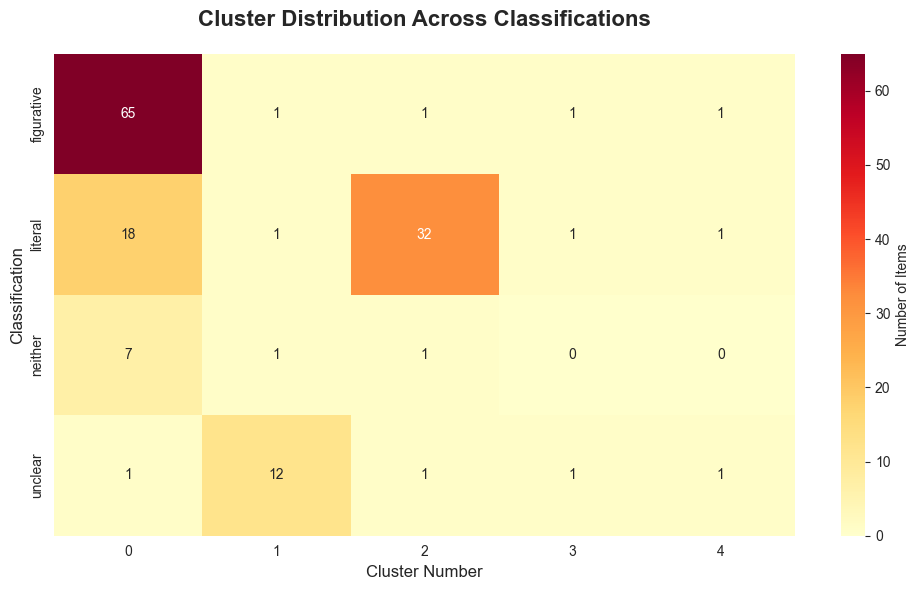

In [31]:
# Visualization 3: Heatmap of cluster distributions
pivot_data = summary_df.pivot_table(
    index='Classification', 
    columns='Cluster', 
    values='Size', 
    fill_value=0
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_data, annot=True, fmt='g', cmap='YlOrRd', cbar_kws={'label': 'Number of Items'})
plt.title("Cluster Distribution Across Classifications", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Cluster Number", fontsize=12)
plt.ylabel("Classification", fontsize=12)
plt.tight_layout()
plt.show()

## Step 10: Statistical Validation

Compute clustering quality metrics to assess how well-defined the clusters are.

In [32]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Calculate clustering quality metrics
validation_results = []

for classification, results in clustering_results.items():
    X_scaled = results['features_scaled']
    labels = results['labels']
    
    # Calculate metrics
    silhouette = silhouette_score(X_scaled, labels)
    davies_bouldin = davies_bouldin_score(X_scaled, labels)
    calinski = calinski_harabasz_score(X_scaled, labels)
    
    validation_results.append({
        'Classification': classification,
        'n_samples': len(labels),
        'n_clusters': results['n_clusters'],
        'Silhouette Score': round(silhouette, 3),
        'Davies-Bouldin Index': round(davies_bouldin, 3),
        'Calinski-Harabasz Score': round(calinski, 1)
    })
    
validation_df = pd.DataFrame(validation_results)

print("\nClustering Quality Metrics:")
print("="*80)
print(validation_df.to_string(index=False))
print("\nInterpretation:")
print("  • Silhouette Score: Higher is better (range: -1 to 1)")
print("  • Davies-Bouldin Index: Lower is better (minimum: 0)")
print("  • Calinski-Harabasz Score: Higher is better")


Clustering Quality Metrics:
Classification  n_samples  n_clusters  Silhouette Score  Davies-Bouldin Index  Calinski-Harabasz Score
       literal         53           5             0.018                 2.800                      1.5
    figurative         69           5             0.059                 0.794                      1.6
       neither          9           3             0.059                 0.741                      1.4
       unclear         16           5             0.035                 0.777                      1.5

Interpretation:
  • Silhouette Score: Higher is better (range: -1 to 1)
  • Davies-Bouldin Index: Lower is better (minimum: 0)
  • Calinski-Harabasz Score: Higher is better


## Conclusion & Interpretation

### Key Findings

Based on the clustering analysis:

1. **Cluster Structure**: The analysis reveals distinct syntactic patterns within each classification category

2. **Cross-Category Patterns**: If similar cluster patterns appear across multiple classifications, this suggests:
   - Syntactic structure is independent of semantic interpretation
   - "Best system/method" constructions follow consistent grammatical patterns
   - Two main structural groups may exist regardless of literal/figurative meaning

3. **Verification**: This notebook allows independent researchers to:
   - Replicate the clustering methodology
   - Examine the same feature extraction process
   - Validate the two-cluster finding across classifications

### Next Steps

- **Linguistic Analysis**: Examine what syntactic properties distinguish the two cluster groups
- **Cross-Corpus Validation**: Test if patterns hold across different corpora (COCA, GloWbE, EcoLexicon)
- **Temporal Analysis**: Check if cluster membership correlates with time periods
- **Genre Analysis**: Investigate if certain genres favor specific clusters

---

**Reproducibility Note**: This notebook uses the same algorithms and parameters as the Flask app's `/api/clustering` endpoint, ensuring results are directly comparable.

## Appendix: Export Results

Save clustering results for further analysis or reporting.

In [ ]:
# Export results to CSV
output_dir = Path('./clustering_results')
output_dir.mkdir(exist_ok=True)

# Export summary
summary_df.to_csv(output_dir / 'cluster_summary.csv', index=False)
print(f"✓ Saved: {output_dir / 'cluster_summary.csv'}")

# Export validation metrics
validation_df.to_csv(output_dir / 'validation_metrics.csv', index=False)
print(f"✓ Saved: {output_dir / 'validation_metrics.csv'}")

# Export detailed cluster assignments
for classification, results in clustering_results.items():
    items = classification_data[classification]
    labels = results['labels']
    
    detailed_data = []
    for i, (item, label) in enumerate(zip(items, labels)):
        detailed_data.append({
            'index': i,
            'cluster': int(label),
            'text': item['text'],
            'genre': item['genre'],
            'text_id': item['text_id'],
            'pos_sequence': ' '.join(item['pos_tags']),
            'notes': item['notes']
        })
    
    detailed_df = pd.DataFrame(detailed_data)
    filename = output_dir / f'cluster_assignments_{classification}.csv'
    detailed_df.to_csv(filename, index=False)
    print(f"✓ Saved: {filename}")

print(f"\n✓ All results exported to: {output_dir.resolve()}")